## NN Base

### Final Result

Test Set RMSE:33.53

Whole Grid Rmse:35.25514

### Data Preparation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#import hvplot.xarray
import sys

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-12-24 19:28:09.133541: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-12-24 19:28:09.133562: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Reading Data
dir_name="../../data/member_001"

chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2=read_xarray(dir_name)

mld=mld.isel(bnds=0)
sss=sss.isel(bnds=0)
sst=sst.isel(bnds=0)
xco2=xco2.isel(bnds=0)


mld['time'] =mld.time.indexes['time'].to_datetimeindex()
sss['time'] =sss.time.indexes['time'].to_datetimeindex()
sst['time'] =sst.time.indexes['time'].to_datetimeindex()
xco2['time'] =xco2.time.indexes['time'].to_datetimeindex()


pco2['time'] = pco2.time.dt.strftime("%Y-%m")
chl['time'] = chl.time.dt.strftime("%Y-%m")
mld['time'] =mld.time.dt.strftime("%Y-%m")
sss['time'] =sss.time.dt.strftime("%Y-%m")
sst['time'] =sst.time.dt.strftime("%Y-%m")
xco2['time'] =xco2.time.dt.strftime("%Y-%m")


data_read=xr.merge([chl.Chl,chl.Chl_socat,mld.MLD,mld.MLD_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat,xco2,pco2.pCO2,pco2.pCO2_socat])

tmp_data=data_read.to_dataframe().reset_index()
tmp_data=tmp_data.drop(columns=['TLONG', 'TLAT', 'time_bnds'])

check=tmp_data.set_index(["time","ylat","xlon"]).to_xarray()

tmp_data_final=tmp_data[tmp_data.time != "1982-01"]
tmp_data_final=tmp_data_final[tmp_data_final.time != "2017-02"]

features_socat = ['time','xlon', 'ylat','MLD_socat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['time','xlon', 'ylat','MLD','SST','SSS','Chl','XCO2','pCO2']

# create separate dataframe for socat
combined_socat=tmp_data_final[features_socat]
combined=tmp_data_final[features]

combined_socat.dropna(subset = ["pCO2_socat"],inplace=True)
combined_socat= combined_socat[combined_socat['pCO2_socat']!=0]

combined.dropna(subset = ["pCO2"],inplace=True)
combined= combined[combined['pCO2']!=0]

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/tmp/ipykernel_406644/132348747.py:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  mld['time'] =mld.time.indexes['time'].to_datetimeindex()
/tmp/ipykernel_406644/132348747.py:13: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sss['time'] =sss.time.indexes['time'].to_datetimeindex()


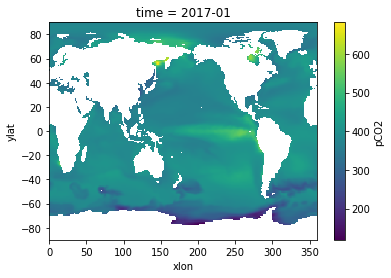

In [3]:
check.pCO2[420].plot()

In [4]:
X_socat=combined_socat.iloc[:,3:-1]
X=combined.iloc[:,3:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']


In [5]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
    ])

In [6]:
X_socat=num_pipeline.fit_transform(X_socat)
X=num_pipeline.fit_transform(X)

In [7]:
def FFN_Model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, kernel_initializer='normal')])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    
    return model

In [8]:
X_socat_train, X_socat_test, y_socat_train, y_socat_test = train_test_split(
    X_socat, y_socat, test_size=0.3, random_state= 73)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state= 73)


In [9]:
model_path = '../../models/Simple_NN_Full.h5'

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 

In [10]:
n_epochs = 50

model = FFN_Model()
history = model.fit(X_socat_train, y_socat_train, epochs=n_epochs, 
                    batch_size=2056, validation_data=(X_socat_test, y_socat_test),callbacks=callbacks)

2022-12-24 19:28:58.431285: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-24 19:28:58.431650: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-12-24 19:28:58.431665: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-24 19:28:58.431681: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (g001): /proc/driver/nvidia/version does not exist
2022-12-24 19:28:58.431941: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical 

Epoch 1/50
84/84 [==============================] - 3s 35ms/step - loss: 101163.2206 - mse: 101163.2206 - val_loss: 2292574.5000 - val_mse: 2292574.5000
Epoch 2/50
84/84 [==============================] - 2s 29ms/step - loss: 2857.4439 - mse: 2857.4439 - val_loss: 91309.7188 - val_mse: 91309.7188
Epoch 3/50
84/84 [==============================] - 2s 29ms/step - loss: 1979.0975 - mse: 1979.0975 - val_loss: 6333.2817 - val_mse: 6333.2817
Epoch 4/50
84/84 [==============================] - 2s 29ms/step - loss: 1735.8122 - mse: 1735.8122 - val_loss: 1907.7616 - val_mse: 1907.7616
Epoch 5/50
84/84 [==============================] - 2s 29ms/step - loss: 1655.0871 - mse: 1655.0871 - val_loss: 1501.4677 - val_mse: 1501.4677
Epoch 6/50
84/84 [==============================] - 2s 29ms/step - loss: 1580.9324 - mse: 1580.9324 - val_loss: 1421.4760 - val_mse: 1421.4760
Epoch 7/50
84/84 [==============================] - 2s 29ms/step - loss: 1533.5157 - mse: 1533.5157 - val_loss: 1380.8475 - val_ms

### Prediction On Full

In [11]:
y_pred=model.predict(X,verbose=1)

539044/539044 [==============================] - 277s 514us/step


In [17]:
y_pred=y_pred.flatten()

In [19]:
y_pred.shape

(17249400,)

In [21]:
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred

final_test_rmse

35.57608456340653

### Visualization of Residual

In [22]:
combined["residual"] = error
combined["pred"] = y_pred

combined_tmp=combined.set_index(["time","ylat","xlon"])
result_data=combined_tmp[["residual"]]
result_data = result_data.sort_index()

combined_tmp=combined.set_index(["time","ylat","xlon"])
pred_data=combined_tmp[["pred","pCO2"]]
pred_data = pred_data.sort_index()

ds = result_data.to_xarray()
ds_pred = pred_data.to_xarray()

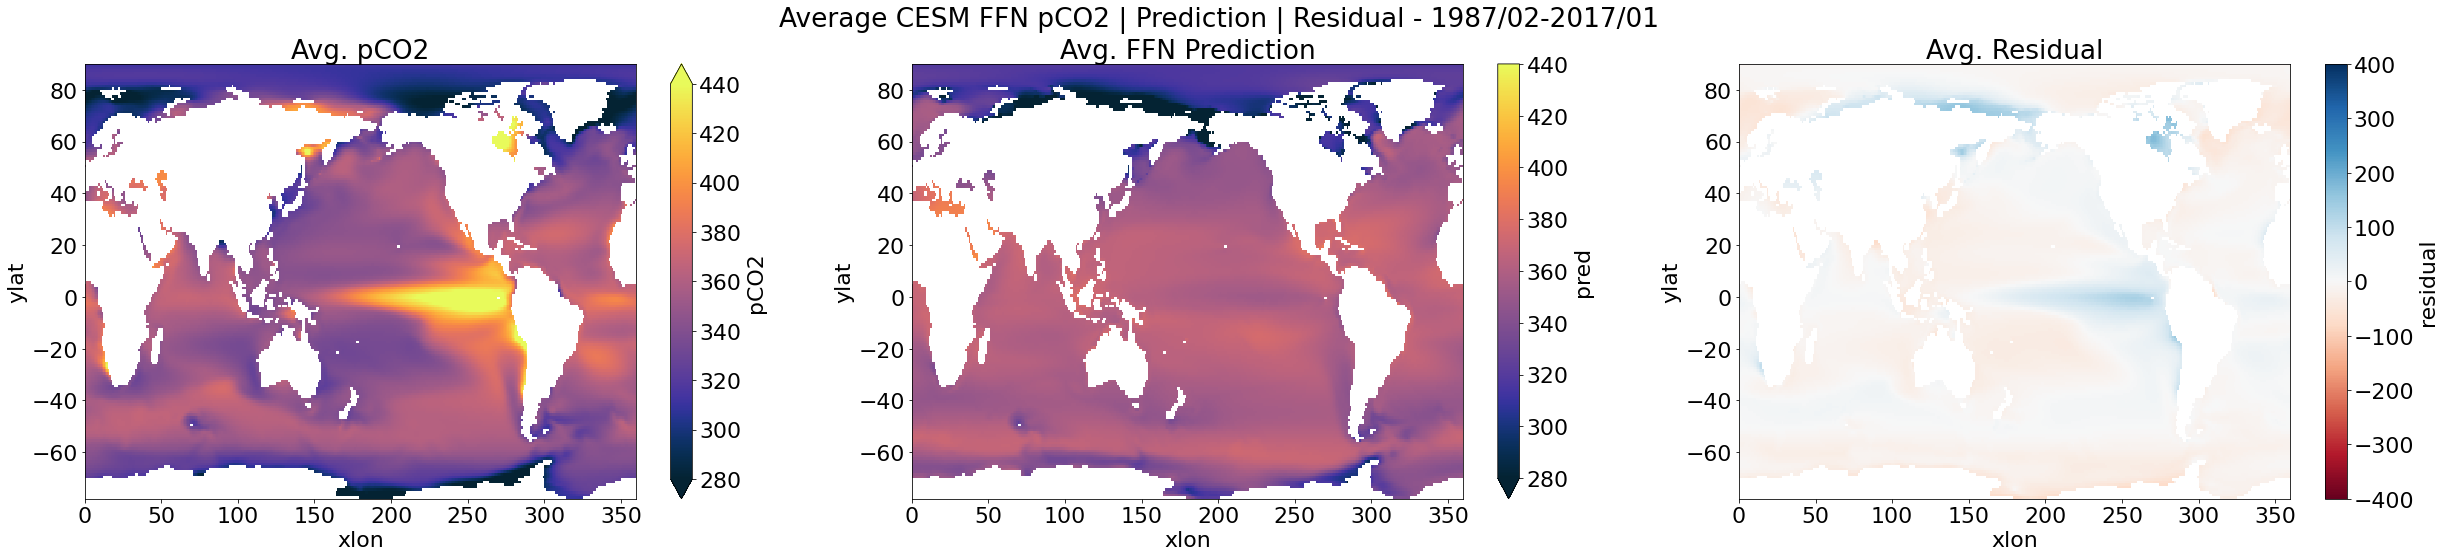

In [23]:
import matplotlib.colors as mcolors
import cmocean as cm

plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
figure, axis = plt.subplots(1, 3,figsize=(42, 8))

ds_pred.pCO2.mean('time').plot(ax = axis[0],cmap = cm.cm.thermal,norm=norm)
axis[0].set_title("Avg. pCO2")

ds_pred.pred.mean('time').plot(ax = axis[1],cmap = cm.cm.thermal,norm=norm)
axis[1].set_title("Avg. FFN Prediction")


norm2 = mcolors.TwoSlopeNorm(vmin=-400, vmax = 400, vcenter=0)

ds.residual.mean('time').plot(ax = axis[2],cmap = "RdBu",norm=norm2)
axis[2].set_title("Avg. Residual")

figure.suptitle("Average CESM FFN pCO2 | Prediction | Residual - 1987/02-2017/01")

plt.savefig("../../assets/figure2.2_ffn_socat.jpg")